In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile 
from pathlib import Path
import os
from tqdm import tqdm
import sys
sys.path.append(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\10_code\UTvsXCT-preprocessing')
from preprocess_tools import aligner, register, onlypores, reslicer

# AUX

In [2]:
def read_sequence(folder_path):
    """
    Read a sequence of TIFF files in a folder as a 3D volume.
    
    Args:
    folder_path (str): Path to the folder containing TIFF files.

    Returns:
    numpy.ndarray: A 3D array where each slice corresponds to a TIFF file.
    """

    # List and sort the TIFF files
    tiff_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if (f.endswith('.tiff') or f.endswith('.tif'))])
    
    # Get the total number of TIFF files
    total_files = len(tiff_files)
    
    # Read each TIFF file and update progress
    volume = []
    with tqdm(total=total_files, desc="Progress") as pbar:
        for i, file_path in enumerate(tiff_files):
            slice_data = tifffile.imread(file_path)
            volume.append(slice_data)
            
            # Update progress
            pbar.update(1)
    
    return np.array(volume)

# Load

In [3]:
filename = Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Juan Ignacio\probetas\4\volume_eq')

data = read_sequence(filename)

Progress: 100%|██████████| 3224/3224 [00:41<00:00, 77.83it/s]


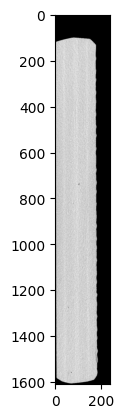

In [4]:
plt.imshow(data[50], cmap='gray')

# Get angles

In [ ]:
#data axes are y,x,z, so we need to transpose it to z,y,x
data = np.transpose(data, (2, 0, 1))
data.shape

In [8]:
angle_yz, angle_xz = register.YZ_XZ_inclination(data,'XCT')

Finding surface points: 100%|██████████| 4774524/4774524 [03:23<00:00, 23471.80it/s]


In [11]:
from joblib import Parallel, delayed
from scipy.ndimage import rotate

def rotate_volume(volume, angle_yz, angle_xz, n_jobs=-1):
    """
    Rotate a 3D volume based on estimated angles in the YZ and XZ planes, using parallel processing.
    
    Parameters
    ----------
    volume : numpy.ndarray
        3D volume to be rotated, expected shape (Z, Y, X).
    angle_yz : float
        Angle in degrees to rotate around the X axis (YZ plane).
    angle_xz : float
        Angle in degrees to rotate around the Y axis (XZ plane).
    n_jobs : int, default=-1
        Number of jobs for parallel processing. -1 means using all processors.
        
    Returns
    -------
    rotated_volume : numpy.ndarray
        Rotated 3D volume.
    """
    
    # Define helper function for YZ rotation
    def rotate_yz_slice(i, vol, angle):
        return rotate(vol[:,:,i], angle=angle, reshape=True, cval=40)
    
    # Define helper function for XZ rotation
    def rotate_xz_slice(i, vol, angle):
        return rotate(vol[:,i,:], angle=angle, reshape=True, cval=40)
    
    ###(Y,Z) plane rotation###

    if angle_yz != 0:
    
        #Step 1: Calculate the new shape after rotation in the YZ plane
        yz_new_shape = rotate(volume[:,:,0], angle=angle_yz, reshape=True, cval=40).shape
        
        #Step 2: Process all slices in parallel
        rotated_slices_yz = Parallel(n_jobs=n_jobs)(
            delayed(rotate_yz_slice)(i, volume, angle_yz) 
            for i in tqdm(range(volume.shape[2]), desc="Rotating YZ slices")
        )
        
        #Step 3: Construct the intermediate volume
        rotated_volume_yz = np.zeros((yz_new_shape[0], yz_new_shape[1], volume.shape[2]), dtype=volume.dtype)
        for i, rotated_slice in enumerate(rotated_slices_yz):
            rotated_volume_yz[:,:,i] = rotated_slice
    
    else:

        rotated_volume_yz = volume.copy()
    
    ###(X,Z) plane rotation###

    if angle_xz == 0:
        # If no rotation is needed in the XZ plane, return the YZ rotated volume
        return rotated_volume_yz
    
    #Step 1: Calculate the new shape after rotation in the XZ plane
    xz_new_shape = rotate(rotated_volume_yz[:,0,:], angle=angle_xz, reshape=True, cval=40).shape
    
    #Step 2: Process all slices in parallel
    rotated_slices_xz = Parallel(n_jobs=n_jobs)(
        delayed(rotate_xz_slice)(i, rotated_volume_yz, angle_xz) 
        for i in tqdm(range(rotated_volume_yz.shape[1]), desc="Rotating XZ slices")
    )
    
    #Step 3: Construct the final volume
    rotated_volume_xz = np.zeros((xz_new_shape[0], rotated_volume_yz.shape[1], xz_new_shape[1]), dtype=volume.dtype)
    for i, rotated_slice in enumerate(rotated_slices_xz):
        rotated_volume_xz[:,i,:] = rotated_slice
    
    return rotated_volume_xz

In [12]:
rotated_volume_XCT = rotate_volume(data, angle_yz, angle_xz)

Rotating XZ slices: 100%|██████████| 3228/3228 [00:10<00:00, 295.35it/s]


In [15]:
#undo the transpose
rotated_volume_XCT = np.transpose(rotated_volume_XCT, (1, 2, 0))

rotated_volume_XCT.shape

(3228, 1611, 300)

In [18]:
# Generate a new mask for the aligned volume
mask = onlypores.material_mask_parallel(rotated_volume_XCT)

volume,mask = aligner.centering(rotated_volume_XCT,mask)

computing otsu
Bounding box coordinates: zmin=1, zmax=3226, ymin=1, ymax=1609, xmin=55, xmax=257


In [32]:
volume = reslicer.rotate_90(volume,False)

volume = reslicer.reslice(volume,'Bottom')

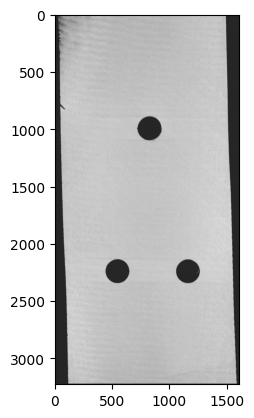

In [43]:
plt.imshow(volume[7, :, :], cmap='gray')

In [ ]:
# #save the aligned volume as a tiff file
# output_path = filename.parent / 'centered.tif'
# tifffile.imwrite(output_path, cropped_aligned_volume)